In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import sys
sys.path.append('/remote/tychodata/ftairli/work/Projects/TraceHexConv/Models')

In [2]:
plt.rcParams['figure.figsize'] = [15, 12]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using Device:', device)

D_main_test = torch.load('../Data/NormData/D_main_test.pt')
D_main_test = D_main_test.to_dense()
D_aux_test  = torch.load('../Data/NormData/D_aux_test.pt')
logE_test   = torch.load('../Data/NormData/logE_test.pt')
xmax_test   = torch.load('../Data/NormData/Xmax_test.pt')
axis_test   = torch.load('../Data/NormData/Axis_test.pt')
core_test   = torch.load('../Data/NormData/Core_test.pt')



Using Device: cuda


Model_5_0


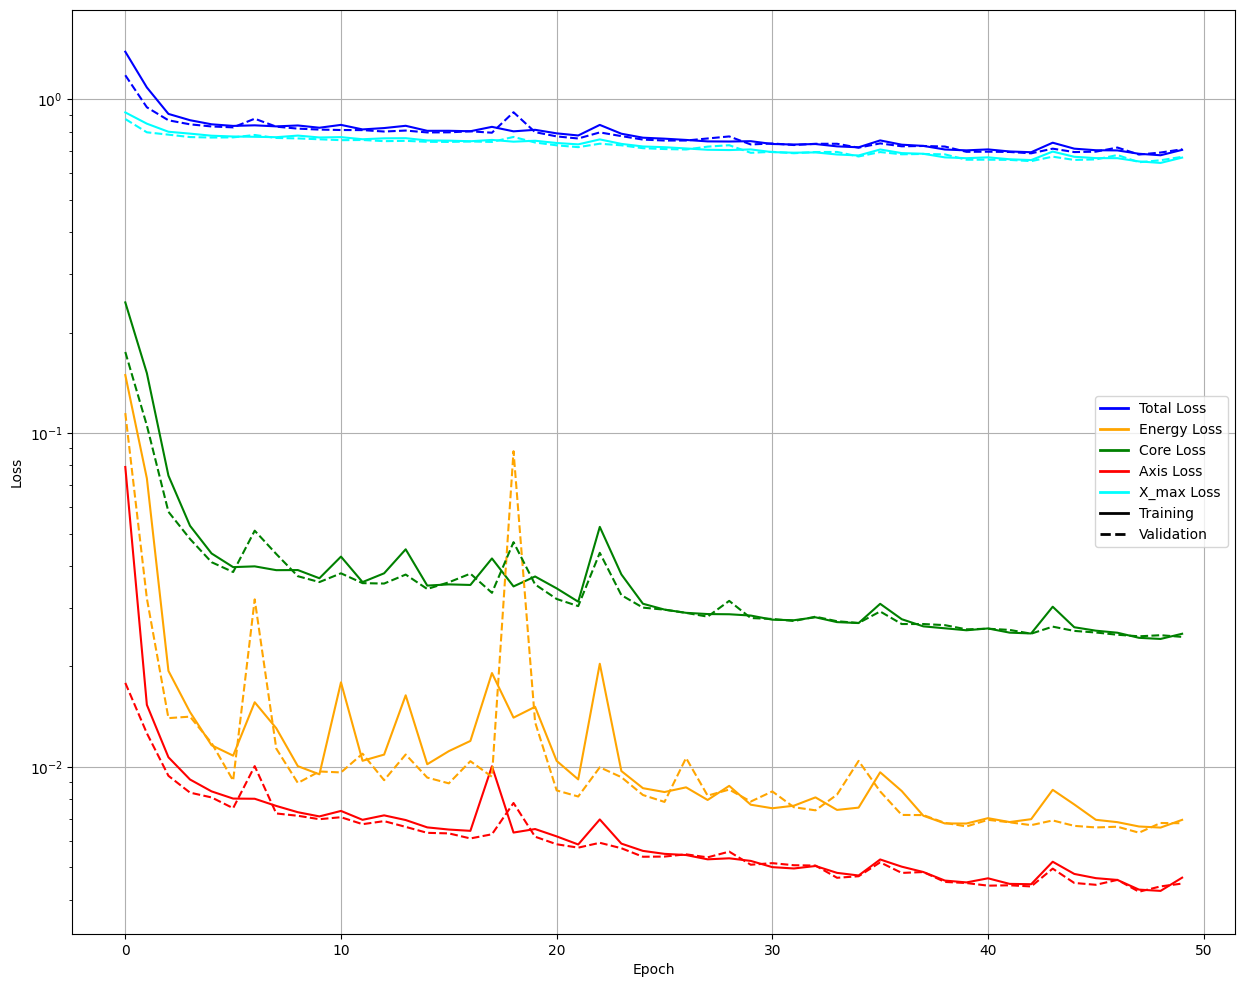

In [6]:
model = torch.load('../Models/Model_5_0.pt')
print(model.Name)
weights = np.asarray(model.LossCoefficients)
weights[np.where(weights==0)] = 1

tracker = torch.load('../Models/Model_5_0_Tracker.pt')
E_loss = np.asarray(tracker.EpochLoss_E)/weights[0]
E_loss_val = np.asarray(tracker.EpochValLoss_E)/weights[0]

C_loss = np.asarray(tracker.EpochLoss_C)/weights[1]
C_loss_val = np.asarray(tracker.EpochValLoss_C)/weights[1]

A_loss = np.asarray(tracker.EpochLoss_A)/weights[2]
A_loss_val = np.asarray(tracker.EpochValLoss_A)/weights[2]

X_loss = np.asarray(tracker.EpochLoss_X)/weights[3]
X_loss_val = np.asarray(tracker.EpochValLoss_X)/weights[3]

T_loss = E_loss + C_loss + A_loss + X_loss
T_loss_val = E_loss_val + C_loss_val + A_loss_val + X_loss_val

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan']

# Plot training loss
plt.plot(T_loss, color=colors[0], label='Total Loss - Training')
plt.plot(E_loss, color=colors[1], label='Energy Loss - Training')
plt.plot(C_loss, color=colors[2], label='Core Loss - Training')
plt.plot(A_loss, color=colors[3], label='Axis Loss - Training')
plt.plot(X_loss, color=colors[4], label='Xmax Loss - Training')

# Plot validation loss
plt.plot(T_loss_val, color=colors[0], linestyle='dashed', label='Total Loss - Validation')
plt.plot(E_loss_val, color=colors[1], linestyle='dashed', label='Energy Loss - Validation')
plt.plot(C_loss_val, color=colors[2], linestyle='dashed', label='Core Loss - Validation')
plt.plot(A_loss_val, color=colors[3], linestyle='dashed', label='Axis Loss - Validation')
plt.plot(X_loss_val, color=colors[4], linestyle='dashed', label='Xmax Loss - Validation')

# Set up custom legend

custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color=colors[3], lw=2),
                Line2D([0], [0], color=colors[4], lw=2),
                Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', linestyle='dashed', lw=2)]

plt.legend(custom_lines, ['Total Loss', 'Energy Loss', 'Core Loss', 'Axis Loss','X_max Loss', 'Training', 'Validation'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.show()


In [9]:
model = model.to(device)
model.eval()

from Model_5_0 import MyDataset
from torch.utils.data import SubsetRandomSampler, DataLoader
data_test        = (D_main_test,D_aux_test)
targets_test     = (logE_test,core_test,axis_test,xmax_test)

BatchSize      = 100

test_dataset = MyDataset(data_test,targets_test)
dataloader_test = DataLoader(test_dataset,batch_size=BatchSize)

logE_pred = np.zeros(shape = (D_main_test.shape[0],1))
core_pred = np.zeros(shape = (D_main_test.shape[0],2))
axis_pred = np.zeros(shape = (D_main_test.shape[0],3))
xmax_pred = np.zeros(shape = (D_main_test.shape[0],1))

logE_test = np.zeros(shape = (D_main_test.shape[0],1))
core_test = np.zeros(shape = (D_main_test.shape[0],2))
axis_test = np.zeros(shape = (D_main_test.shape[0],3))
xmax_test = np.zeros(shape = (D_main_test.shape[0],1))


filled = 0
BatchN = 0
print('Beginging to compute')
with torch.no_grad():
    for batchD_main,batchD_aux, batchlogE,batchCore,batchAxis,batchxmax in dataloader_test:

        print(f'\rBatch {BatchN} of {len(dataloader_test)}',end='')

        batchD_main = batchD_main.to(device)
        batchD_aux = batchD_aux.to(device)
        Current_BatchSize = batchD_main.shape[0]
        
        Results = model(batchD_main,batchD_aux)
        Truths  = (batchlogE,batchCore,batchAxis,batchxmax)

        logE_pred[filled: filled+Current_BatchSize] = Results[0].cpu().numpy()
        core_pred[filled: filled+Current_BatchSize] = Results[1].cpu().numpy()
        axis_pred[filled: filled+Current_BatchSize] = Results[2].cpu().numpy()
        xmax_pred[filled: filled+Current_BatchSize] = Results[3].cpu().numpy()

        logE_test[filled: filled+Current_BatchSize] = Truths[0].cpu().numpy()
        core_test[filled: filled+Current_BatchSize] = Truths[1].cpu().numpy()
        axis_test[filled: filled+Current_BatchSize] = Truths[2].cpu().numpy()
        xmax_test[filled: filled+Current_BatchSize] = Truths[3].cpu().numpy()

        
        filled += Current_BatchSize
        BatchN += 1

del model

Beginging to compute
Batch 236 of 237

Text(0.5, 1.0, 'Energy Prediction')

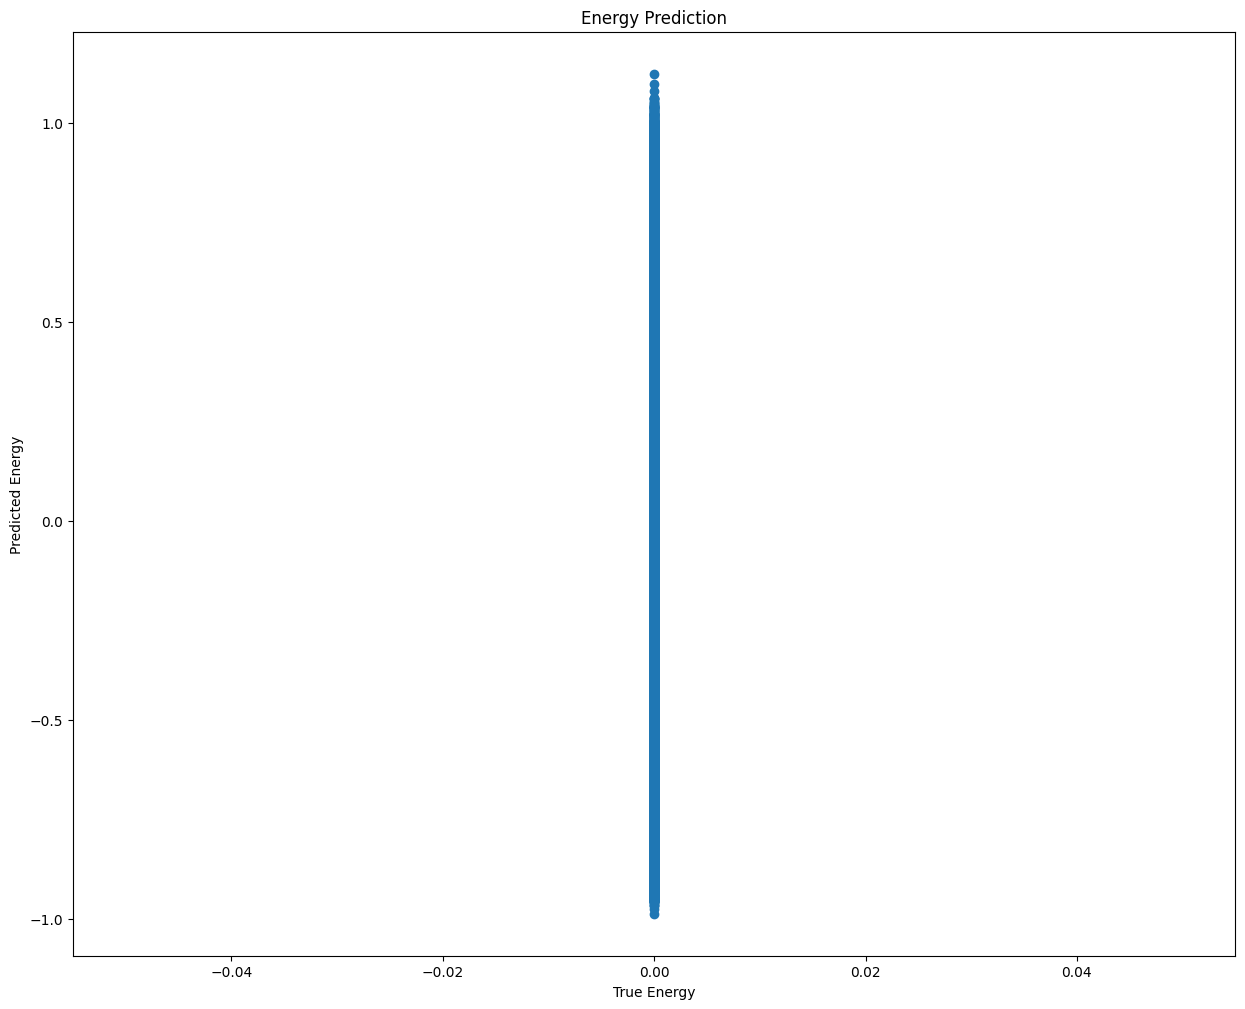

In [11]:
plt.scatter(logE_test,logE_pred)
# plt.plot([18,20],[18,20],color ='red')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.title('Energy Prediction')

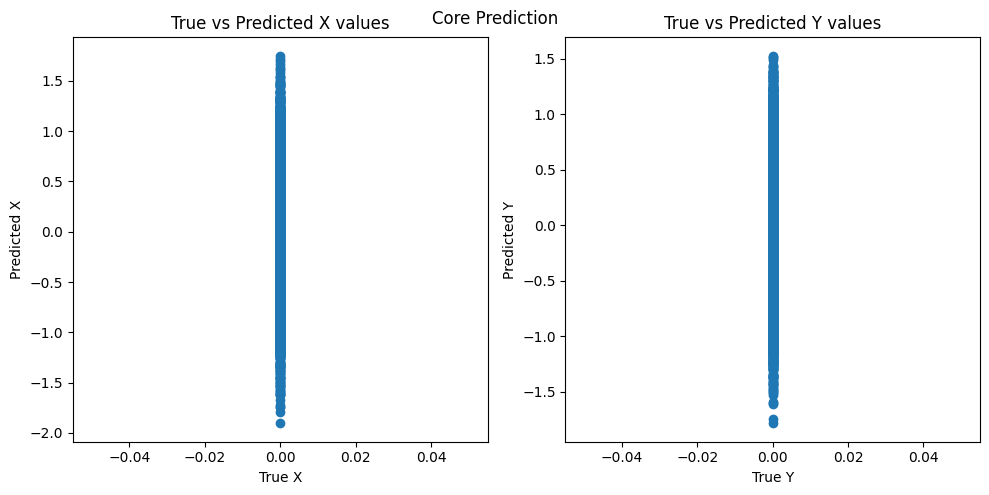

In [12]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
true_x = core_test[:,0]
pred_x = core_pred[:,0]
true_y = core_test[:,1]
pred_y = core_pred[:,1]

# plot for X values
axs[0].scatter(true_x, pred_x)
axs[0].plot([min(true_x), max(true_x)], [min(true_x), max(true_x)], color='red')  # ideal line
axs[0].set_xlabel('True X')
axs[0].set_ylabel('Predicted X')
axs[0].set_title('True vs Predicted X values')

# plot for Y values
axs[1].scatter(true_y, pred_y)
axs[1].plot([min(true_y), max(true_y)], [min(true_y), max(true_y)], color='red')  # ideal line
axs[1].set_xlabel('True Y')
axs[1].set_ylabel('Predicted Y')
axs[1].set_title('True vs Predicted Y values')

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()
plt.suptitle('Core Prediction')
plt.show()

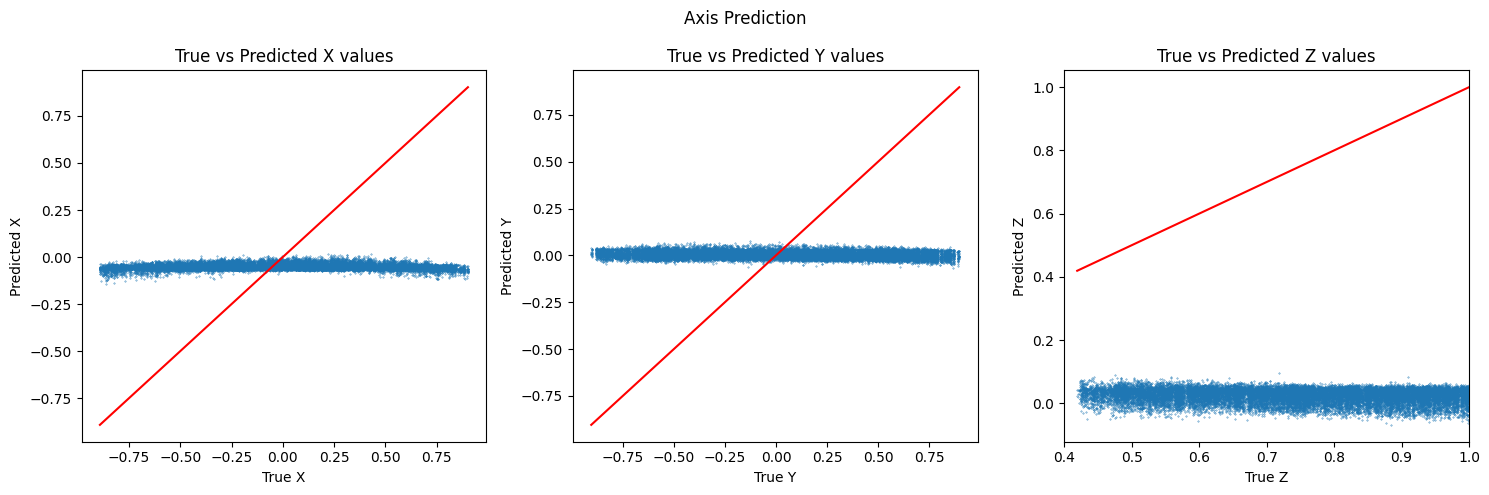

In [25]:
fig, ax =plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(axis_test[:,0],axis_pred[:,0],s=0.1)
ax[0].plot([min(axis_test[:,0]), max(axis_test[:,0])], [min(axis_test[:,0]), max(axis_test[:,0])], color='red')  # ideal line
ax[0].set_xlabel('True X')
ax[0].set_ylabel('Predicted X')
ax[0].set_title('True vs Predicted X values')

ax[1].scatter(axis_test[:,1],axis_pred[:,1],s=0.1)
ax[1].plot([min(axis_test[:,1]), max(axis_test[:,1])], [min(axis_test[:,1]), max(axis_test[:,1])], color='red')  # ideal line
ax[1].set_xlabel('True Y')
ax[1].set_ylabel('Predicted Y')
ax[1].set_title('True vs Predicted Y values')

ax[2].scatter(axis_test[:,2],axis_pred[:,2],s=0.1)
ax[2].plot([min(axis_test[:,2]), max(axis_test[:,2])], [min(axis_test[:,2]), max(axis_test[:,2])], color='red')  # ideal line
ax[2].set_xlabel('True Z')
ax[2].set_ylabel('Predicted Z')
ax[2].set_title('True vs Predicted Z values')
ax[2].set_xlim(0.4,1)
plt.suptitle('Axis Prediction')
plt.tight_layout()
plt.show()


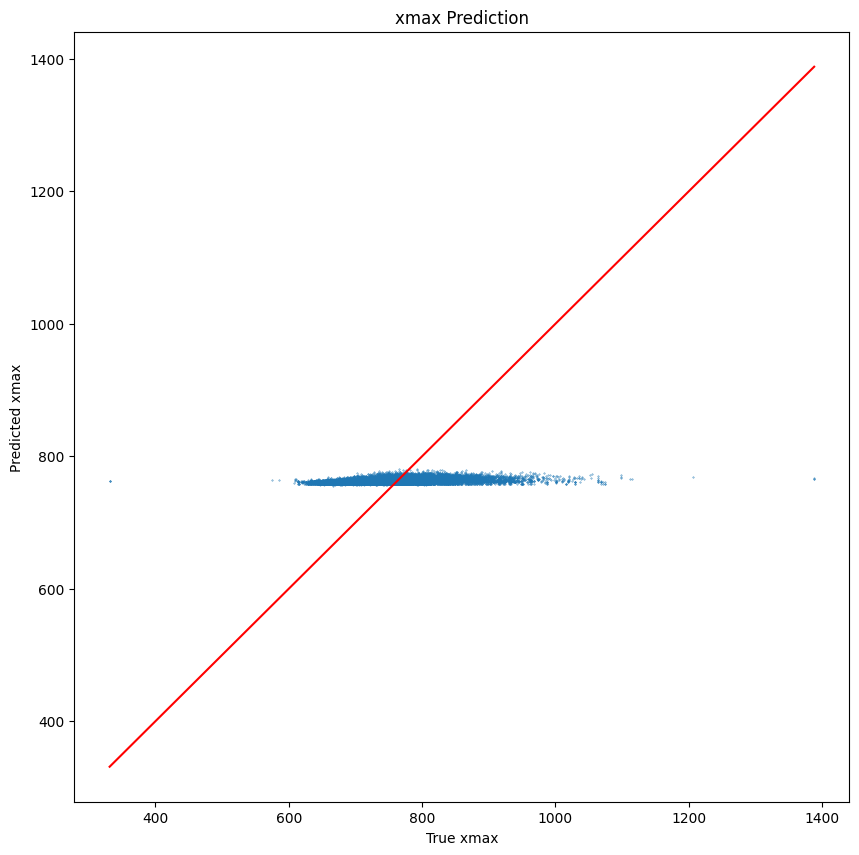

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(xmax_test,xmax_pred,s=0.1)
plt.plot([min(xmax_test), max(xmax_test)], [min(xmax_test), max(xmax_test)], color='red')  # ideal line
plt.xlabel('True xmax')
plt.ylabel('Predicted xmax')
plt.title('xmax Prediction')
plt.show()

<Figure size 1000x1000 with 0 Axes>

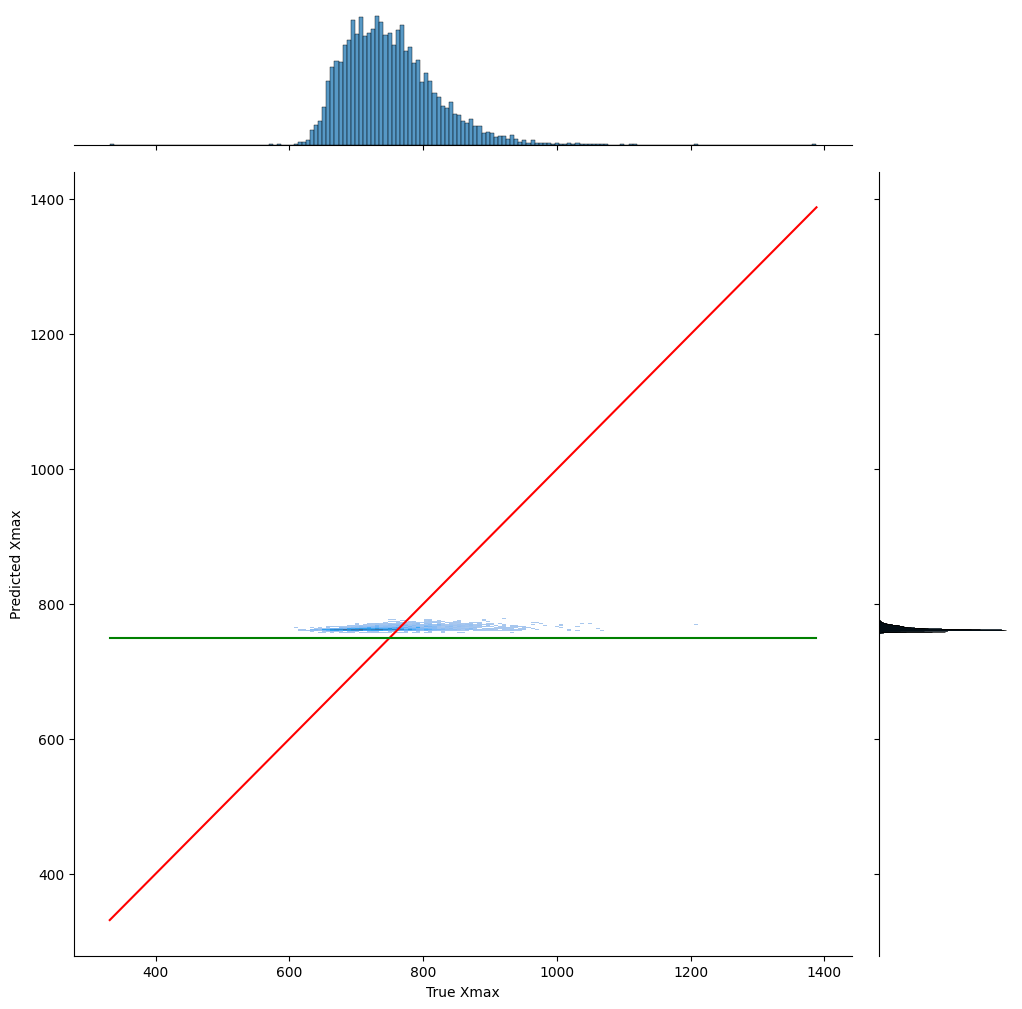

In [27]:
import seaborn as sns

# make a 2d histogram plot of Xmax and Predicted Xmax
plt.figure(figsize=(10,10))
fig = sns.jointplot(x=xmax_test[:,0],y=xmax_pred[:,0],kind = 'hist', height =10)
fig.ax_joint.plot([min(xmax_test[:,0]), max(xmax_test[:,0])], [min(xmax_test[:,0]), max(xmax_test[:,0])], color='red')  # ideal line
# plot line at Y=750 for the mean
fig.ax_joint.plot([min(xmax_test[:,0]), max(xmax_test[:,0])], [750, 750], color='green')  # ideal line
fig.set_axis_labels('True Xmax', 'Predicted Xmax')


In [28]:
def angle_between_vectors(v1, v2):
    dot_product = np.sum(v1*v2, axis=1)
    magnitude_v1 = np.linalg.norm(v1, axis=1)
    magnitude_v2 = np.linalg.norm(v2, axis=1)
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    theta = np.arccos(np.clip(cos_theta, -1, 1)) # to avoid floating-point errors
    theta = np.degrees(theta)
    return theta

# # Substitute cause the above stopped working for some reason
# def angle_between_vectors(v1, v2):
#     dot_product = np.sum(v1*v2, axis=1)
#     theta = np.arccos(np.clip(dot_product,-1,1))
#     theta = np.degrees(theta)
#     return theta

In [29]:
E_res = np.abs(10**(logE_pred[:,0]-logE_test[:,0])-1)
C_res = np.linalg.norm(core_pred -core_test,axis =1)
A_norm = np.sqrt(axis_pred[:,0]**2 + axis_pred[:,1]**2 + axis_pred[:,2]**2)
A_res = angle_between_vectors(axis_pred,axis_test)
X_res = np.sqrt((xmax_test[:] - xmax_pred[:])**2)


E_res = E_res[np.where(E_res<np.percentile(E_res,99))]
C_res = C_res[np.where(C_res<np.percentile(C_res,99))]
A_res = A_res[np.where(A_res<np.percentile(A_res,99))]
X_res = X_res[np.where(X_res<np.percentile(X_res,99))]

print(E_res.shape)
print(C_res.shape)
print(A_res.shape)
print(X_res.shape)

(23444,)
(23444,)
(23444,)
(23444,)


In [30]:
axis_test.shape

(23681, 3)

Text(0.95, 0.95, '$\\sigma_{68} = 67.24^\\circ$')

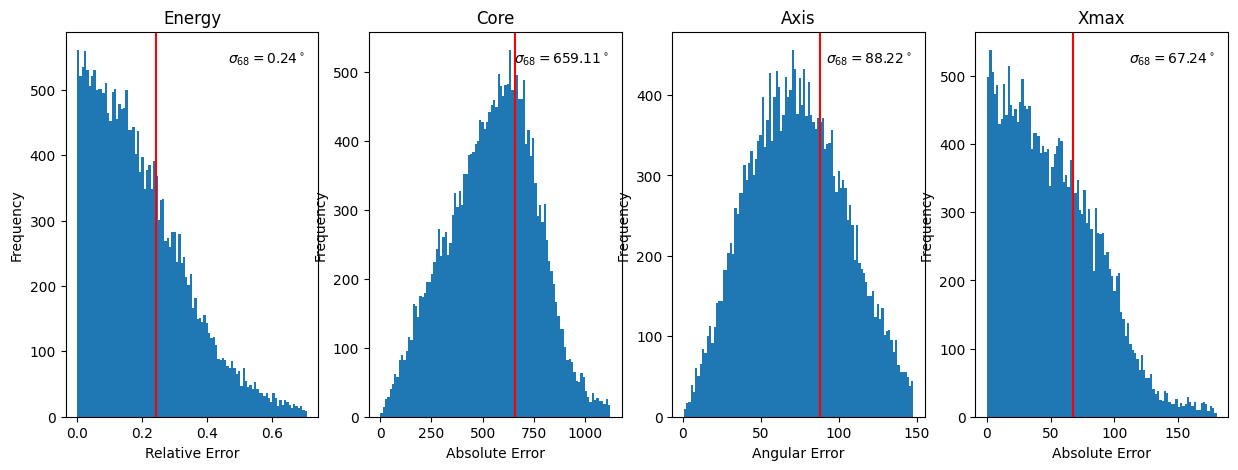

In [31]:
fig, ax = plt.subplots(1,4,figsize=(15,5))

reso = np.percentile(E_res,68)
ax[0].hist(E_res,bins=100)
ax[0].set_xlabel('Relative Error')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Energy')
# ax[0].set_yscale('log')
ax[0].axvline(reso,color='red',label='68%')
ax[0].text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=ax[0].transAxes)


reso = np.percentile(C_res,68)
ax[1].hist(C_res,bins=100)
ax[1].set_xlabel('Absolute Error')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Core')
# ax[1].set_yscale('log')
ax[1].axvline(reso,color='red',label='68%')
ax[1].text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=ax[1].transAxes)

reso = np.percentile(A_res,68)
ax[2].hist(A_res,bins=100)
ax[2].set_xlabel('Angular Error')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Axis')
# ax[2].set_yscale('log')
ax[2].axvline(np.percentile(A_res,68),color='red',label='68%')
ax[2].text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=ax[2].transAxes)

reso = np.percentile(X_res,68)
ax[3].hist(X_res,bins=100)
ax[3].set_xlabel('Absolute Error')
ax[3].set_ylabel('Frequency')
ax[3].set_title('Xmax')
# ax[3].set_yscale('log')
ax[3].axvline(np.percentile(X_res,68),color='red',label='68%')
ax[3].text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=ax[3].transAxes)
